In [12]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool
sys.path.append('../..')
import loaders
import data
from extern.quarterTools import data_scaler

import warnings
from lightkurve import LightkurveWarning
warnings.filterwarnings("ignore", category=LightkurveWarning)



SEED = 12345
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
### Uncomment to mount the drive and/or bucket

#lcs stored on drive for quick access
data.mount_drive('/mnt/disks/lcs/')

#other data products stored on google bucket
!gcsfuse --implicit-dirs tess-goddard-lcs /home/jupyter/mountpoint

Disk mounted
I0707 21:13:00.023470 2023/07/07 21:13:00.023423 Start gcsfuse/0.42.4 (Go version go1.19.7) for app "" using mount point: /home/jupyter/mountpoint
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithConn: Mount: mount: running /usr/bin/fusermount: exit status 1


# Features

In [14]:
from extern import features

In [15]:
def get_subset(s):
    """Returns the subset features used to rescore a sector.
    
    Note: only Sector 18 has been rescored and had the reference subset
    saved as of 7/7/2023. 
    """
    try:
        df = feats  # if feats is defined in an earlier block
    except:
        datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
        df = pd.read_hdf(datafile, f"S{s}/features")

    subset_tics = np.loadtxt(f"/home/jupyter/mountpoint/dataproducts/s{s}_score_reference.txt")
    sample_subset = df.loc[subset_tics]
    return sample_subset

from sklearn import preprocessing

def data_scaler(data_to_scale, s=18):
    """Scales given features by the same factors as the given sector.
    
    This method recalculates the factors needed to scale each feature for a
    given sector. The features are scaled and shifted such that each set of
    features has a mean of zero and a standard deviation of one for
    the features calculated for all light curves in the given sector.
    
    Though possible, newly scaled data should not be expected to have a mean
    of zero or a standard a deviation of one for any feature.
    """
    try:
        df = feats.iloc[:, 0:61]
    except: 
        datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
        df = pd.read_hdf(datafile, f"S{s}/features")[:, 0:61]  # including mstat but not astat

    scaler = preprocessing.StandardScaler().fit(df)
    scaled = scaler.transform(data_to_scale)
    scaled = pd.DataFrame(index=data_to_scale.index,
                                columns=df.columns,
                                data=scaled)
    return scaled

def score_scaler(score):
    """Rescales "raw" scores to match Sector 18 rescored
    
    Calculated based on reference points. Not perfect, but pretty good
    Note: can't do similar to data_scaler because "raw" scores aren't saved
    """
    factor = 0.00018255470902209855
    offset = -4.34047914797675e-12
    scaled = score*factor+offset
    return scaled

def dist_scores(ref_data, d2s=None, k=1, scaler=False):
    """
    This method calculates the distance to the k-th neighbor in the reference data
    Args:
        ref_data (Numpy array or Pandas dataframe) - The reference data to which
            distances will be calculated
        d2s (Numpy array or Pandas dataframe) - Data to be scored (if None,
            same as the reference data)
        k (integer) - neighbor to calculate the distance

    Returns:
        scores (Numpy array) - distances for data in d2s.
    """


    if isinstance(d2s, type(None)):
        # if d2s is a dataframe, the evaluation of d2s==None tries to compare
        # every value of the dataframe to None, instead we check if it's
        # NoneType
        d2s = ref_data  # will default to full data if d2s is not specified

    if isinstance(scaler, type(data_scaler)):
        ref_data = scaler(ref_data)
        d2s = scaler(d2s)
    nbrs = NearestNeighbors(
        n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1).fit(ref_data)
    distances, indices = nbrs.kneighbors(d2s)

    scores = score_scaler(distances[:, k])

    return scores

KeyError: 'Flux7'

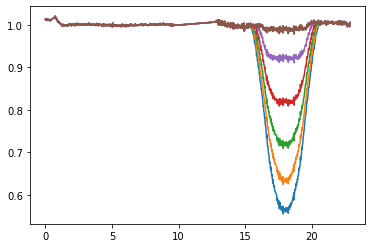

In [27]:
shape = "Triangle"
fluxes = pd.read_csv(shape+ "_depth.csv")
for num in range(1,13):
    plt.plot(fluxes['Time'].values,fluxes["Flux%s" %(num)].values)
print(fluxes)


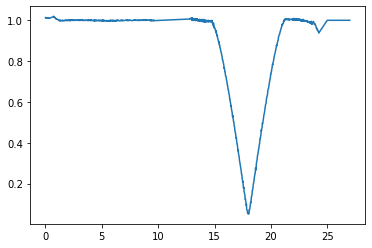

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0  0.222019   -2.473936 -0.00081  3.422739  0.798713       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.132255   -0.023211  ...        1.57809   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.167036 -3.514703 -3.605423 -3.149605 -0.818011  0.593386    0.022112   

   magratio     mstat  
0 -0.024393  3.059928  

[1 rows x 61 columns]
7056.0


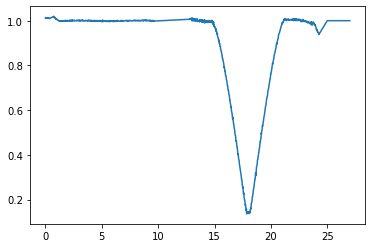

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.206168   -2.286319 -0.000816  3.147934  0.770803       -0.866391   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.13477   -0.024849  ...       1.394967   

       mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.19886 -3.509154 -3.610401 -3.218247 -0.968639  0.517447    0.019341   

   magratio     mstat  
0 -0.024365  3.066219  

[1 rows x 61 columns]
8339.0


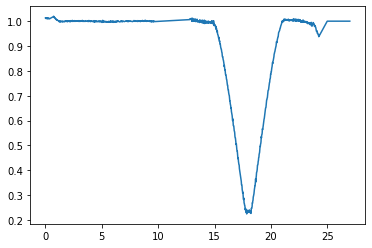

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.187509   -2.074904 -0.000823  2.833021  0.756848       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.163049     -0.0266  ...       1.178222   

        mbp     mid20     mid35     mid50     mid65   mid80  percentamp  \
0  0.220077 -3.507958 -3.602766 -3.300195 -1.111034  0.4481    0.016422   

   magratio     mstat  
0 -0.024323  3.070413  

[1 rows x 61 columns]
9809.0


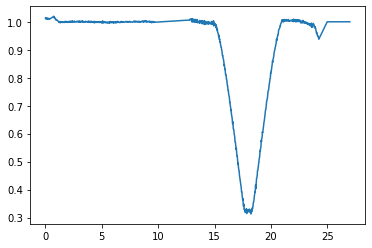

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0  0.167982   -1.860429 -0.00083  2.512088  0.756848       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.161319   -0.028254  ...       0.958012   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.246597 -3.504788 -3.613857 -3.471226 -1.306442  0.405524    0.013494   

   magratio     mstat  
0 -0.024271  3.070413  

[1 rows x 61 columns]
12380.0


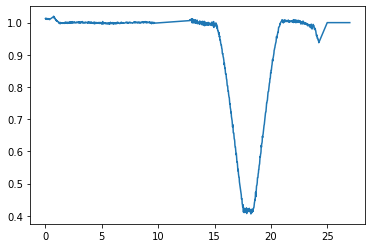

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.146459   -1.631157 -0.000836  2.167473  0.742893       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.164036   -0.029458  ...       0.711096   

        mbp     mid20    mid35     mid50     mid65     mid80  percentamp  \
0  0.267814 -3.495693 -3.61047 -3.576943 -1.487055  0.379358    0.010441   

   magratio     mstat  
0 -0.024202  3.068316  

[1 rows x 61 columns]
14377.0


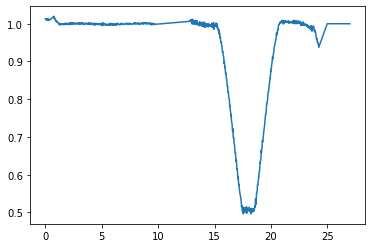

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.124022   -1.397115 -0.000842  1.817445  0.714983       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.183579   -0.030562  ...       0.452638   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.294334 -3.489488 -3.614448 -3.642844 -1.700152  0.419471    0.007457   

   magratio     mstat  
0 -0.024109  3.062025  

[1 rows x 61 columns]
16853.0


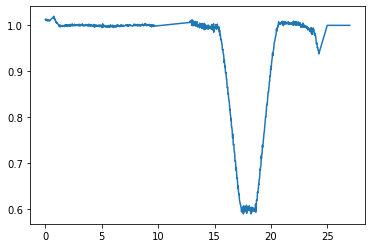

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.099648   -1.148409 -0.000848  1.447081  0.728938       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.180191   -0.031553  ...        0.17345   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.310246 -3.462286 -3.589932 -3.674866 -1.859596  0.832184    0.004379   

   magratio     mstat  
0 -0.023973  3.047345  

[1 rows x 61 columns]
16410.0


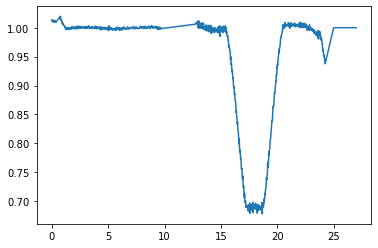

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.074985   -0.903325 -0.000853  1.082105  0.714983       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.203437   -0.033027  ...      -0.095866   

       mbp     mid20     mid35     mid50     mid65   mid80  percentamp  \
0  0.31555 -3.434545 -3.559166 -3.686988 -2.021665  1.2867    0.001453   

   magratio     mstat  
0 -0.023771  3.017985  

[1 rows x 61 columns]
16712.0


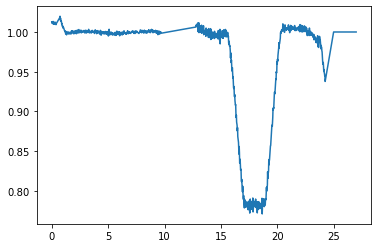

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.048318   -0.641624 -0.000856  0.697741  0.728938       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.212566    -0.03369  ...       -0.36151   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.363287 -3.372092 -3.507395 -3.629656 -2.148772  2.032013   -0.001602   

   magratio     mstat  
0 -0.023396  2.955071  

[1 rows x 61 columns]
15547.0


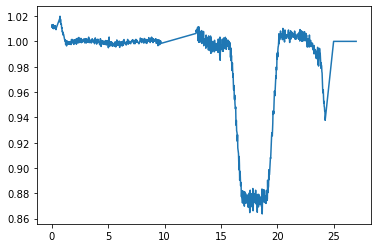

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.020289   -0.373828 -0.000859   0.30452  0.742893       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.243718   -0.034597  ...      -0.606451   

        mbp     mid20     mid35    mid50     mid65     mid80  percentamp  \
0  0.331463 -3.231564 -3.378089 -3.42985 -1.599147  2.681916   -0.004666   

   magratio     mstat  
0 -0.022542  2.793591  

[1 rows x 61 columns]
15390.0


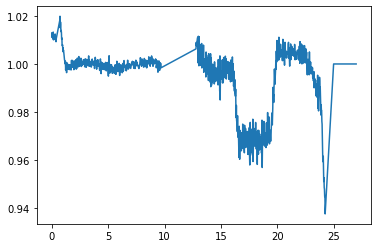

      stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0 -0.00823   -0.098065 -0.00086 -0.085074  1.733694       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -0.885174    -1.884852 -0.256466   -0.035257  ...      -0.779027   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0 -0.342158 -2.555548 -2.537012 -2.267904 -0.698322  1.949645     -0.0071   

   magratio     mstat  
0 -0.018922  2.036525  

[1 rows x 61 columns]
30617.0


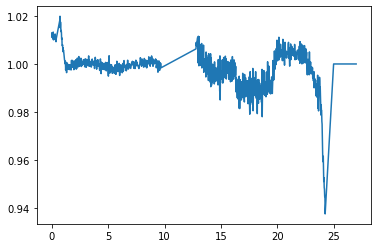

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0 -0.013152   -0.035692 -0.00086 -0.151332   1.55228       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0         0.99438     0.191341 -0.289167   -0.035517  ...        -0.8039   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0 -0.379287 -1.806038 -1.600624 -0.987708 -0.268459  0.771544   -0.007098   

   magratio     mstat  
0 -0.018156  1.126368  

[1 rows x 61 columns]
51556.0
[ 7056.  8339.  9809. 12380. 14377. 16853. 16410. 16712. 15547. 15390.
 30617. 51556.]


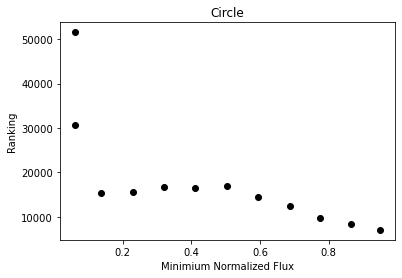

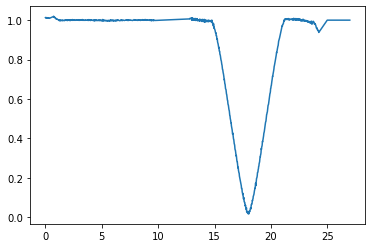

      stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.25432   -2.895469 -0.000795  4.009477  0.966172       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.127942   -0.022122  ...       1.661947   

        mbp     mid20    mid35    mid50  mid65     mid80  percentamp  \
0  0.129907 -3.527197 -3.62137 -3.06747 -0.214  1.091699     0.02328   

   magratio     mstat  
0 -0.024407  3.020082  

[1 rows x 61 columns]
5972.0


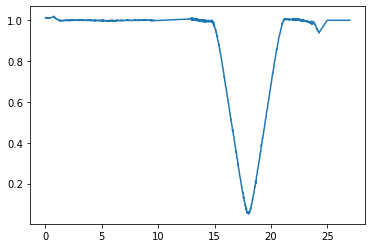

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.241331   -2.724584 -0.000801  3.769787  0.938262       -0.866391   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.13477   -0.022618  ...       1.592483   

        mbp     mid20     mid35     mid50     mid65    mid80  percentamp  \
0  0.151123 -3.523745 -3.623978 -3.184457 -0.350603  0.95994    0.022134   

   magratio     mstat  
0 -0.024397  3.028471  

[1 rows x 61 columns]
6894.0


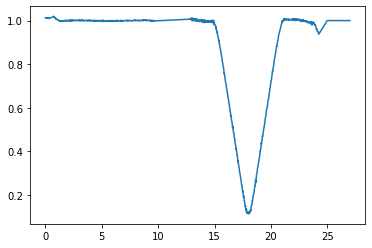

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0  0.221794    -2.48171 -0.00081  3.420591  0.882443       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.163954    -0.02394  ...       1.457719   

        mbp     mid20    mid35     mid50     mid65     mid80  percentamp  \
0  0.193556 -3.522548 -3.62586 -3.283168 -0.494319  0.839207    0.020097   

   magratio     mstat  
0 -0.024375  3.036859  

[1 rows x 61 columns]
7439.0


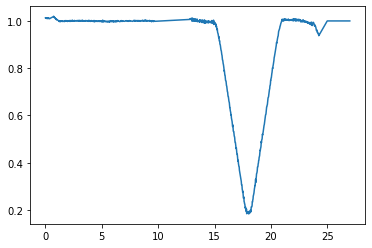

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.201852   -2.245198 -0.000818  3.075661  0.854533       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.158914   -0.025202  ...       1.292581   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.220077 -3.518667 -3.629875 -3.383917 -0.659164  0.769006     0.01777   

   magratio     mstat  
0 -0.024345  3.041053  

[1 rows x 61 columns]
8449.0


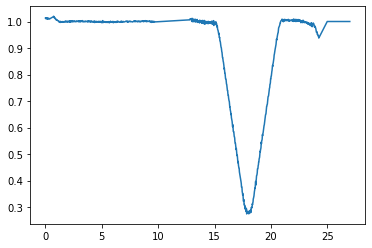

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.178213   -1.979902 -0.000826  2.680312  0.826623       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.159187   -0.027335  ...       1.051718   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.257205 -3.511615 -3.630417 -3.572655 -0.843141  0.685095    0.014766   

   magratio     mstat  
0 -0.024298  3.043151  

[1 rows x 61 columns]
10189.0


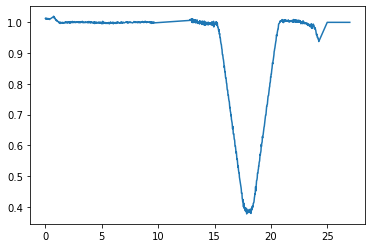

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.152852   -1.703886 -0.000835  2.269475  0.798713       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.181207   -0.029319  ...       0.774033   

        mbp     mid20    mid35     mid50     mid65     mid80  percentamp  \
0  0.283726 -3.504725 -3.63573 -3.650677 -1.098893  0.583098    0.011381   

   magratio     mstat  
0 -0.024226  3.045248  

[1 rows x 61 columns]
12669.0


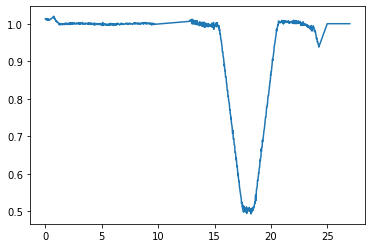

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.123982   -1.400309 -0.000842  1.817102  0.784758       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.174899   -0.030235  ...       0.447963   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.294334 -3.489459 -3.617928 -3.708396 -1.426652  0.521482    0.007544   

   magratio     mstat  
0 -0.024112  3.043151  

[1 rows x 61 columns]
17132.0


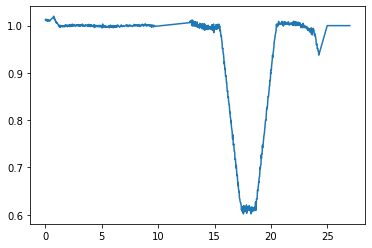

      stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.09575    -1.11341 -0.000849  1.388978  0.784758       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.197908   -0.031629  ...       0.132024   

        mbp     mid20     mid35    mid50    mid65     mid80  percentamp  \
0  0.310246 -3.467651 -3.600303 -3.74978 -1.62342  0.759811    0.003967   

   magratio     mstat  
0 -0.023951  3.030568  

[1 rows x 61 columns]
16258.0


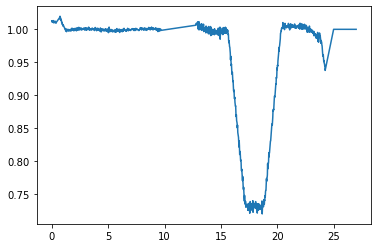

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.062799   -0.784574 -0.000854  0.905236  0.742893       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.211939    -0.03332  ...      -0.215847   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.347375 -3.415251 -3.550049 -3.712118 -1.913308  1.381598     0.00007   

   magratio     mstat  
0 -0.023633  2.990722  

[1 rows x 61 columns]
19414.0


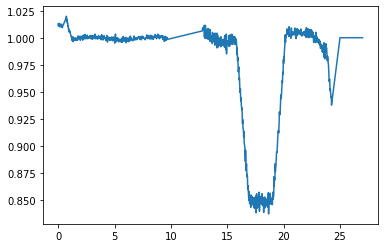

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.028346   -0.451727 -0.000858  0.416487  0.728938       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.242226   -0.034339  ...      -0.540125   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.342071 -3.290827 -3.428898 -3.526191 -1.698421  2.568389   -0.003785   

   magratio     mstat  
0 -0.022886  2.864894  

[1 rows x 61 columns]
15654.0


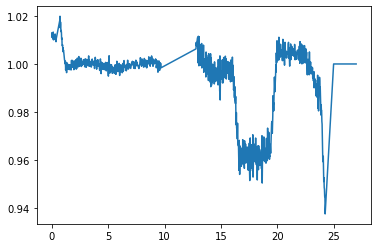

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0 -0.006391   -0.117194 -0.00086  -0.06025  1.510415       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.252193   -0.035147  ...      -0.769401   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0 -0.225468 -2.694344 -2.689864 -2.436895 -0.845792  2.143539   -0.007101   

   magratio     mstat  
0 -0.019442  2.168645  

[1 rows x 61 columns]
27595.0


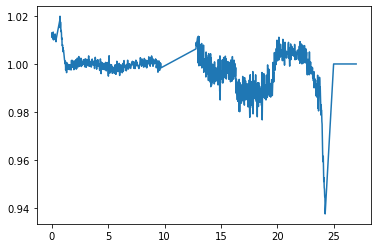

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0 -0.012943   -0.039484 -0.00086 -0.148523  1.733694       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0        0.823511     0.002596 -0.282681   -0.035455  ...      -0.803227   

        mbp     mid20     mid35    mid50     mid65    mid80  percentamp  \
0 -0.405807 -1.844978 -1.663527 -1.04704 -0.217478  0.94752   -0.007098   

   magratio     mstat  
0 -0.018153  1.210254  

[1 rows x 61 columns]
47529.0
[ 5972.  6894.  7439.  8449. 10189. 12669. 17132. 16258. 19414. 15654.
 27595. 47529.]


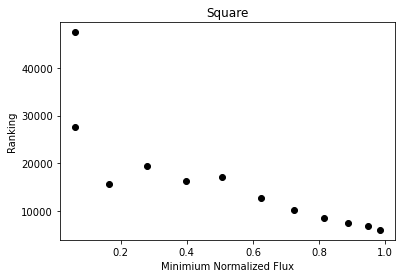

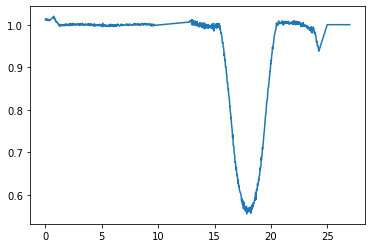

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.107009   -1.204065 -0.000846  1.555945  0.714983       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.198521    -0.03154  ...       0.285178   

        mbp     mid20     mid35     mid50    mid65     mid80  percentamp  \
0  0.347375 -3.478636 -3.615651 -3.781256 -2.03552  1.243973    0.005513   

   magratio     mstat  
0 -0.024029  3.041053  

[1 rows x 61 columns]
17480.0


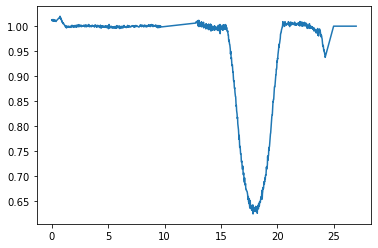

      stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.08635   -1.001287 -0.000851  1.247906  0.714983       -0.866391   

   numnegoutliers  numoutliers     mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.2076   -0.032466  ...        0.03673   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.363287 -3.454255 -3.591915 -3.764538 -2.194475  1.238355    0.003217   

   magratio     mstat  
0 -0.023902  3.024276  

[1 rows x 61 columns]
18559.0


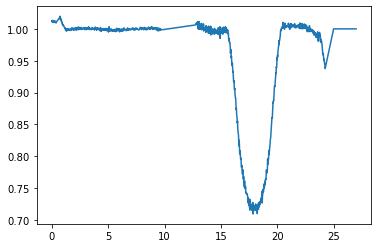

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.063045   -0.775736 -0.000854  0.908132  0.714983       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.212661   -0.033099  ...      -0.226102   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.373896 -3.417485 -3.559876 -3.714153 -2.385803  1.457502    0.000423   

   magratio     mstat  
0 -0.023667  2.990722  

[1 rows x 61 columns]
19477.0


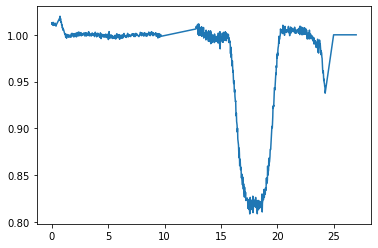

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.035764   -0.516926 -0.000858  0.520151  0.714983       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.228764   -0.033918  ...      -0.490242   

        mbp     mid20     mid35     mid50   mid65     mid80  percentamp  \
0  0.384504 -3.323789 -3.472409 -3.565734 -2.0602  1.954028   -0.002852   

   magratio     mstat  
0 -0.023148  2.908934  

[1 rows x 61 columns]
16774.0


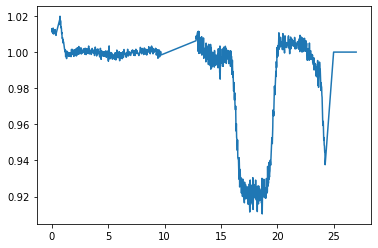

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0  0.005532   -0.233491 -0.00086  0.101646  0.952217       -0.866391   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0       -1.056043    -2.073597 -0.251297   -0.034892  ...      -0.712702   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.156427 -3.066618 -3.177243 -3.108482 -1.803144  2.342759   -0.006204   

   magratio     mstat  
0  -0.02149  2.604849  

[1 rows x 61 columns]
17589.0


KeyError: 'Flux6'

In [29]:
rank_scores = np.array([])
to_score_total = pd.DataFrame()
sector_scores = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/s18rescore.h5", "S18/scores")

for shape in (  'Circle', 'Square', 'Triangle'):
    fluxes = pd.read_csv(shape+ "_depth_spike.csv")
    shape_scores = np.array([])
    shape_depths = np.array([])
    for num in range(1,13):
        plt.plot( fluxes['Time'].values,fluxes["Flux%s" %(num)].values)
        plt.show()

        test_time = fluxes["Time"].values
        test_flux = fluxes["Flux%s" %(num)].values
        test_err = np.zeros_like(test_flux, dtype='uint8')

        test_features = features.feats(test_time, test_flux, test_err)

        test_features = pd.DataFrame(columns=test_features.keys(), data=[test_features.values()])

        mstat = features.calc_mstat(test_flux)

        test_features['mstat'] = mstat
        #print(mstat)

        # Scoring


        sample_subset = get_subset(18)
 

        from sklearn import preprocessing

        feats = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/db.v2.h5", "S18/features")

        data = feats.iloc[:, 0:61] # including mstat but not astat
        scaler = preprocessing.StandardScaler().fit(data)
        scaled_feats = scaler.transform(data)
        scaled_test = scaler.transform(test_features)

        scaled_feats = pd.DataFrame(index=data.index,
                                    columns=data.columns,
                                    data=scaled_feats)

        scaled_test = pd.DataFrame(index=test_features.index,
                                    columns=test_features.columns,
                                    data=scaled_test)

        to_score = scaled_test       
        print(to_score)

        to_score_total = to_score_total.append(to_score)
        
        
        scores = dist_scores(sample_subset, to_score, k=1)
        scores_df = pd.DataFrame(data=scores.T, columns=["scores"])

        # scores_df['rank'] = scores_df.rank(ascending=False).scores.values
        # scores_df["TIC_ID"] = scaled_feats.index
        # del(ref, df, scaled_feats, scores)
        # gc.collect()


        #scale_score(scores[0])

        shape_score = (sector_scores[sector_scores.scores>scale_score(scores[0])]['rank'].max()+1)
        #print(sector_scores.scores)
        #print(print(scale_score(scores[0])))
        #rank_scores = np.append(rank_scores, rank_score)
        print(shape_score)
        
        shape_scores = np.append(shape_scores, shape_score)

        depth = min(fluxes["Flux%s" %(num)].values)
        shape_depths = np.append(shape_depths, depth)
        #print(shape_depths)

        

    shape_depths = 1-shape_depths
    print(shape_scores)
    plt.title(shape)
    plt.xlabel("Minimium Normalized Flux")
    plt.ylabel("Ranking")
    plt.scatter(shape_depths, shape_scores, color = 'black')
    
    plt.show()
    
    #depths_rankings = pd.DataFrame({'Depths':shape_depths, 'Ranking':shape_scores})
    #depths_rankings.to_csv(shape + '_depths_rankings.csv', index=True)


    
#sample_subset.to_csv('sample_subset.csv', index=True)


[17480. 18559. 19477. 16774. 17589.]


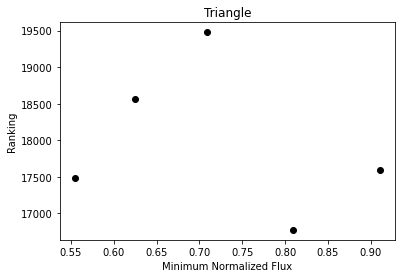

In [22]:
    shape_depths = 1-shape_depths
    print(shape_scores)
    plt.title(shape)
    plt.xlabel("Minimum Normalized Flux")
    plt.ylabel("Ranking")
    plt.scatter(shape_depths, shape_scores, color = 'black')
    
    plt.show()
    
    #depths_rankings = pd.DataFrame({'Depths':shape_depths, 'Ranking':shape_scores})
    #depths_rankings.to_csv('depths_rankings_' + 'triangle' +'.csv', index=True)

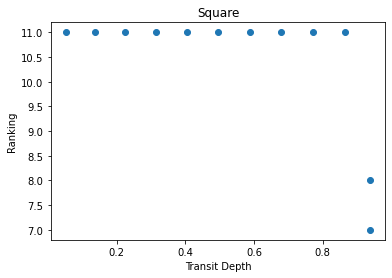

   longtermtrend  meanmedrat     skews     varss  coeffvar      stds  \
0      -0.027380   -2.473933 -0.002588  0.539420 -1.444150 -0.822231   
0      -0.026897   -2.286317 -0.002603  0.439288 -1.444441 -0.825114   
0      -0.026359   -2.074902 -0.002609  0.330073 -1.444773 -0.828507   
0      -0.025800   -1.860428 -0.002610  0.225805 -1.445112 -0.832059   
0      -0.025207   -1.631156 -0.002607  0.122759 -1.445476 -0.835973   
0      -0.024596   -1.397114 -0.002601  0.028601 -1.445846 -0.840054   
0      -0.023942   -1.148409 -0.002591 -0.058341 -1.446237 -0.844486   
0      -0.023304   -0.903325 -0.002578 -0.130052 -1.446622 -0.848972   
0      -0.022622   -0.641624 -0.002556 -0.189183 -1.447028 -0.853822   
0      -0.021921   -0.373828 -0.002500 -0.230717 -1.447444 -0.858919   
0      -0.021199   -0.098065 -0.002216 -0.251292 -1.447855 -0.864106   
0      -0.021033   -0.035692 -0.003068 -0.252629 -1.447925 -0.865001   

   numoutliers  numnegoutliers  numposoutliers   numout1s  ... 

ValueError: x and y must be the same size

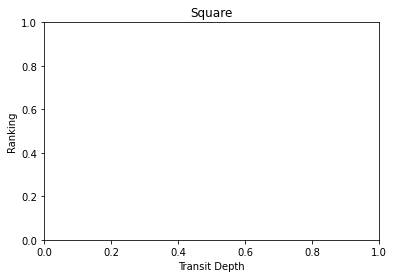

In [99]:
shape_depths = 1-shape_depths
plt.title(shape)
plt.xlabel("Transit Depth")
plt.ylabel("Ranking")
plt.scatter(shape_depths, shape_scores)
plt.show()

print(to_score_total)

to_score_total.to_csv('features.csv', index=True)

print(rank_scores)
#tri_scores=rank_scores

shape_scores = rank_scores#np.array([9., 9., 9., 9. 9. 6.])
shape_depths = np.array([])

for num in range(1,13):
    depth = min(fluxes["Flux%s" %(num)].values)
    shape_depths = np.append(shape_depths, depth)
    
shape_depths = 1-shape_depths
print(shape_depths)

plt.title(shape)
plt.xlabel("Transit Depth")
plt.ylabel("Ranking")
plt.scatter(shape_depths, shape_scores)
print(len(shape_depths), len(shape_scores))


(0.0001, 1.0)

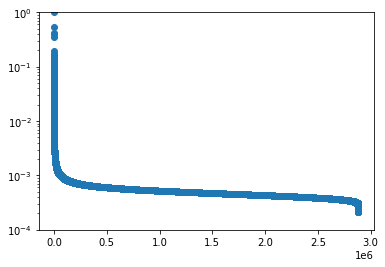

In [143]:
plt.scatter(sector_scores['rank'], sector_scores.scores)
plt.yscale('log')
plt.ylim(1E-4, 1E0)

# Appendix: Scaling distances -> scores

In [65]:
scores_df["TIC_ID"] = sample_subset.index.astype(int)

In [75]:
refpoints = sector_scores[sector_scores.TIC_ID.isin(scores_df.head(2).TIC_ID)].reset_index()

In [69]:
scores_df.head(2)

,scores,TIC_ID
0,2.317967,468603196
1,2.774197,428047465


In [76]:
refpoints

,index,scores,rank,TIC_ID
0,224696,0.000423,2131928.5,468603196
1,2711288,0.000506,1164110.5,428047465


In [89]:
diff_abs = scores_df.head(2).loc[1, 'scores']-scores_df.head(2).loc[0, 'scores']

dif_scaled = refpoints.loc[1,'scores']-refpoints.loc[0,'scores']

factor = dif_scaled/diff_abs

offset = refpoints.loc[1,'scores']-factor*scores_df.head(2).loc[1, 'scores']

In [108]:
print(f"score = {factor:.3E} * distance + {offset:.3E}")

score = 1.826E-04 * distance + -4.340E-12


0    -0.038648
1    -0.037302
2    -0.035795
3    -0.034245
4    -0.032597
5    -0.030904
6    -0.029096
7    -0.027321
8    -0.025428
9    -0.023481
10   -0.021477
11   -0.021017
Name: longtermtrend, dtype: float64


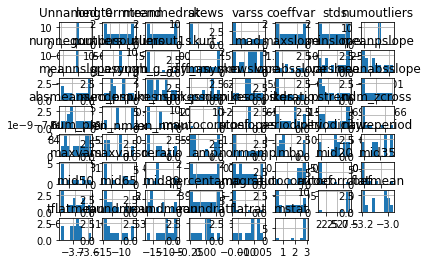

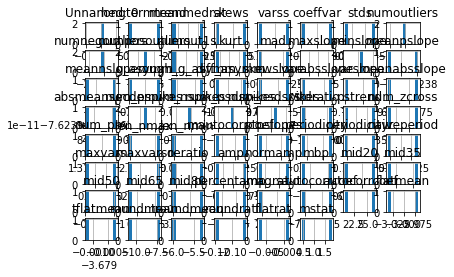

In [27]:
features = pd.read_csv("features.csv")
print(features[features.columns[1]])
outliers = (features.tail(2))


#fig = plt.figure(figsize=(25,30))
#ax = fig.gca()
features.hist()#(ax = ax)
outliers.hist()#(ax = ax)
plt.show()

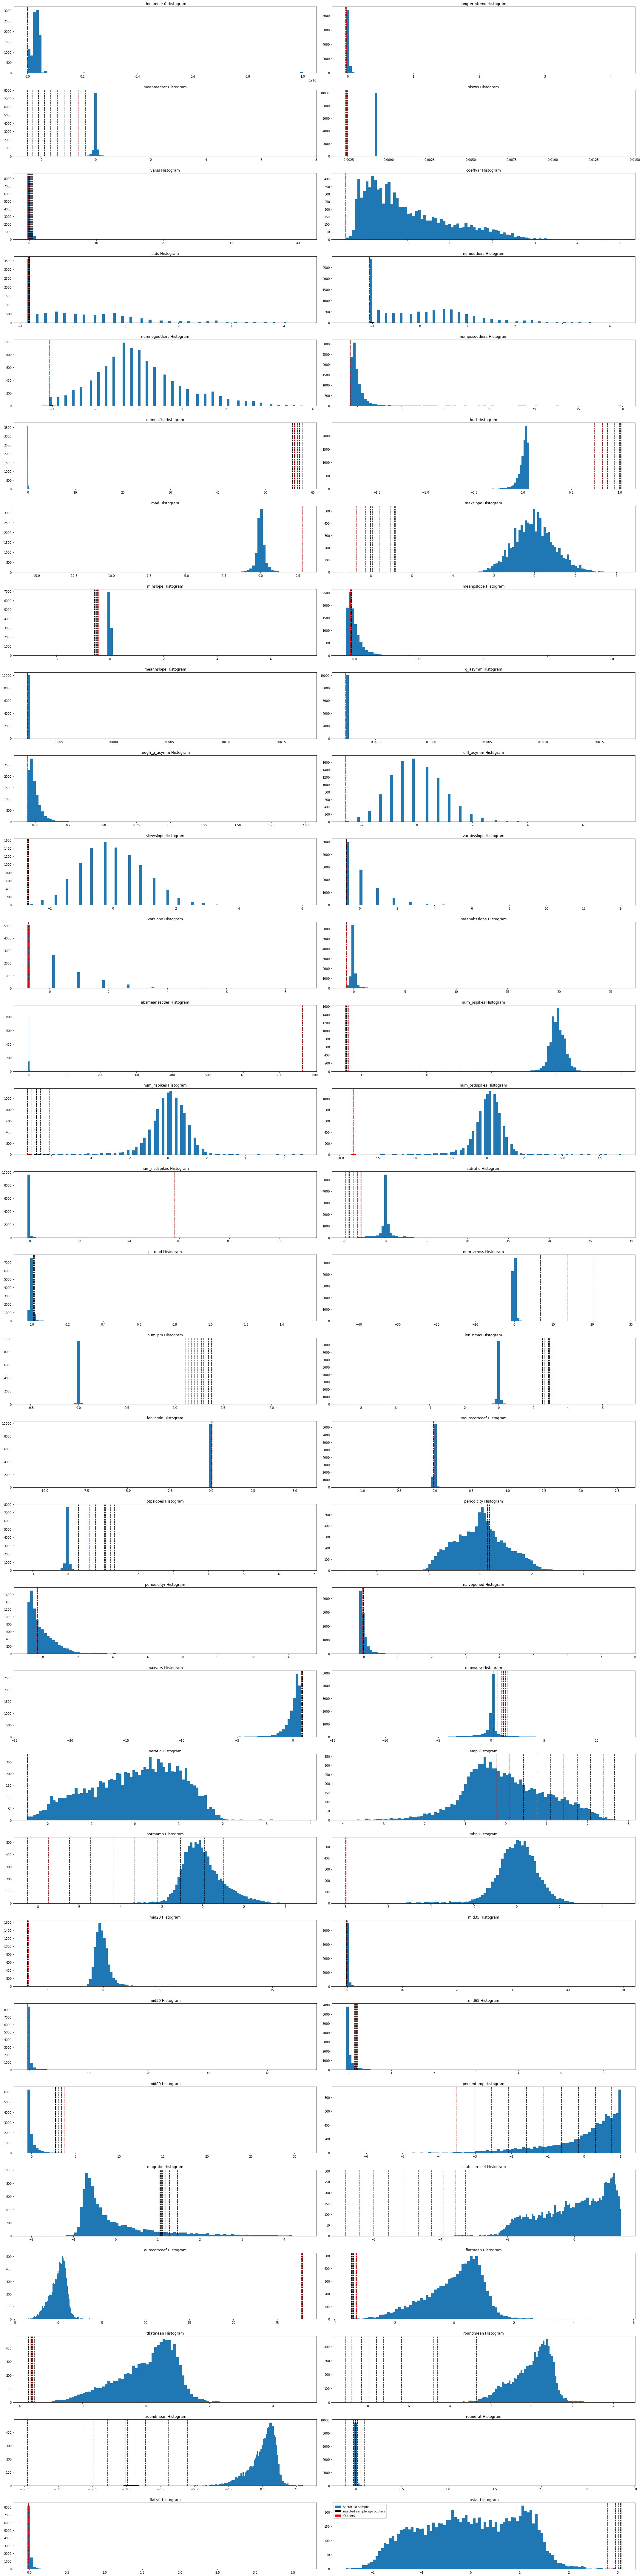

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
sample_subset=pd.read_csv("sample_subset.csv")
features = pd.read_csv("features.csv")
features=features.head(10)
outliers = features.tail(2)

#num_columns = features.shape[1]

num_rows = 6
num_cols = 11

fig, axs = plt.subplots(31, 2, figsize=(30,120))

axs = axs.flatten()

for i, column in enumerate(features.columns):
    axs[i].hist(sample_subset[column], bins=100, label = 'sector 18 sample')
    axs[i].hist(features[column], label = 'injected sample w/o outliers', bins=10, color = 'black')
    axs[i].hist(outliers[column], label='Outliers', color ='red', bins=3)
    axs[i].set_title(f"{column} Histogram")
    
        
    for injected_value in features[column]:
        axs[i].axvline(injected_value, color='black', linestyle='dashed')
    for outlier_value in outliers[column]:
        axs[i].axvline(outlier_value, color='red', linestyle='dashed')


plt.tight_layout()
plt.legend()
plt.show()


In [73]:
mstat_gt_1 = sample_subset[sample_subset['mstat'] > 1]
print(len(mstat_gt_1))


2000
